In [1]:
import sys
import os

relative_path = "/Users/james/Documents/Development/USAT-Designer/.Scripts"
abs_path = os.path.abspath(relative_path)

if abs_path not in sys.path:
    sys.path.insert(0, abs_path)

from universal_transcoder.plots_and_logs import *
from universal_transcoder.calculations.energy_intensity import *
from usat_designer.processing.constants import *
import usat_designer.utils.parameter_utils as pu
from sampling_utils import *

base_save_dir = os.path.join(os.getcwd(), DSN_DIR_BASE)

output_paths = {
    DSN_PLT_PATH_FOCUS_VS_QUALITY_UNFILTERED: os.path.join(base_save_dir, DSN_DIR_PLOTS, DSN_PLT_PATH_FOCUS_VS_QUALITY_UNFILTERED),
    DSN_PLT_PATH_FOCUS_VS_QUALITY_THRESHOLD: os.path.join(base_save_dir, DSN_DIR_PLOTS, DSN_PLT_PATH_FOCUS_VS_QUALITY_THRESHOLD),
    DSN_PLT_PATH_FOCUS_QUALITY_DISTRIBUTION: os.path.join(base_save_dir, DSN_DIR_PLOTS, DSN_PLT_PATH_FOCUS_QUALITY_DISTRIBUTION),
    DSN_PLT_PATH_FOCUS_GRID: os.path.join(base_save_dir, DSN_DIR_PLOTS, DSN_PLT_PATH_FOCUS_GRID),
    DSN_PARAMS_PATH_LOW: os.path.join(base_save_dir, DSN_DIR_USAT_STATE_PARAMETERS, DSN_PARAMS_PATH_LOW),
    DSN_PARAMS_PATH_MID: os.path.join(base_save_dir, DSN_DIR_USAT_STATE_PARAMETERS, DSN_PARAMS_PATH_MID),
    DSN_PARAMS_PATH_HIGH: os.path.join(base_save_dir, DSN_DIR_USAT_STATE_PARAMETERS, DSN_PARAMS_PATH_HIGH)
}

for path in output_paths.values():
    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok=True)

In [2]:
batch_1_discrete    = "/Volumes/James/Batch_Data_2/usat_decodings"
batch_2_continuous  = "/Volumes/James_HD/usat_decodings_3"

df = create_df_from_files(batch_2_continuous, max_folders=3000)

Loading folders: 100%|██████████| 3000/3000 [04:22<00:00, 11.44it/s]


In [3]:
def compute_qs_and_ps(angular_error, source_width, energy):
    
    # Metrics
    ae_mean     = np.mean(angular_error)
    ae_90       = np.percentile(angular_error, 90)

    hist_ae, bins_ae    = np.histogram(angular_error, bins=np.arange(0, 91, 5), density=True)
    epsilon             = 15 # degrees
    cdf_ae              = np.cumsum(hist_ae) * np.diff(bins_ae)
    ae_under_15         = cdf_ae[np.searchsorted(bins_ae[1:], epsilon)]

    sw_median   = np.median(source_width)
    e_std       = np.std(energy)

    # Normalisation
    def normalise(x, min_val, max_val, inverse=False):
        norm = (x - min_val) / (max_val - min_val)
        norm = 1 - norm if inverse else norm
        return np.clip(norm, 0, 1)

    score_ae_mean       = normalise(ae_mean, 0, 45, inverse=True)
    score_ae_90         = normalise(ae_90, 0, 90, inverse=True)
    score_ae_under_15   = ae_under_15
    score_sw_median     = normalise(sw_median, 0, 90, inverse=True)
    score_e_std         = normalise(e_std, 0, 1, inverse=True)

    # P
    P = np.std(source_width)

    # --- Weights ---
    ae_mean_weight      = 0.1
    sw_median_weight    = 0.6
    ae_90_weight        = 0.0
    ae_under_15_weight  = 0.1
    e_std_weight        = 0.2

    weights = [
        ae_mean_weight,
        ae_90_weight,
        ae_under_15_weight,
        sw_median_weight,
        e_std_weight
    ]

    assert int(round(np.sum(weights))) == 1

    q_s = (score_ae_mean * ae_mean_weight +
           score_ae_90   * ae_90_weight +
           score_ae_under_15 * ae_under_15_weight +
           score_sw_median * sw_median_weight +
           score_e_std * e_std_weight) * 100

    return {
        DSN_SMPL_QUALITY_SCORE: float(q_s),
        DSN_SMPL_P: float(P),
        "ae_mean": float(ae_mean),
        "ae_90": float(ae_90),
        "ae_under_15": float(ae_under_15),
        "sw_median": float(sw_median),
        "e_std": float(e_std),
        "score_ae_mean": float(score_ae_mean),
        "score_ae_90": float(score_ae_90),
        "score_ae_under_15": float(score_ae_under_15),
        "score_sw_median": float(score_sw_median),
        "score_e_std": float(score_e_std)
    }

In [4]:
def compute_quality_metrics(df: pd.DataFrame) -> pd.DataFrame:
    
    all_metrics = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing quality metrics"):
        energy = energy_calculation(row[DSN_OUT_SPEAKER_MATRIX])
        ang_error, source_width = get_width_and_angular_error(
            row[DSN_OUT_CLOUD],
            row[DSN_OUT_SPEAKER_MATRIX],
            row[DSN_OUT_OUTPUT_LAYOUT]
        )

        metrics = compute_qs_and_ps(ang_error, source_width, energy)
        all_metrics.append(metrics)

    metrics_df = pd.DataFrame(all_metrics)
    df = pd.concat([df.reset_index(drop=True), metrics_df], axis=1)

    return df

In [5]:
df_q_s  = compute_quality_metrics(df)

metrics = [
    "ae_mean",
    "ae_90",
    "ae_under_15",
    "sw_median",
    "e_std",
    DSN_SMPL_QUALITY_SCORE
]

columns_to_keep = [DSN_SMPL_SEED, DSN_SMPL_P] + metrics
df_q_s          = df_q_s[columns_to_keep].copy()
df_q_s.head(10)

P_counts          = df_q_s[DSN_SMPL_P].value_counts()
unique_P_values   = P_counts[P_counts == 1].index
df_q_s_unique       = df_q_s[df_q_s[DSN_SMPL_P].isin(unique_P_values)].copy()
df_q_s_unique.head(3)

Computing quality metrics: 100%|██████████| 2999/2999 [00:48<00:00, 62.20it/s]


,seed,P,ae_mean,ae_90,ae_under_15,sw_median,e_std,quality_score
16,1011090109,6.824236,8.268895,23.457742,0.815494,32.266598,0.078657,73.233210
18,1012824750,8.341146,7.047711,14.885293,0.900988,33.840092,0.102632,72.831019
31,1022044345,11.338488,24.306393,49.150380,0.414136,80.493744,0.151868,32.040087


In [6]:
print("Correlation between each metric and P (excluding duplicates):\n")

# Ensure we don’t duplicate DSN_SMPL_SEED
metrics_no_seed = [m for m in metrics if m != DSN_SMPL_SEED]


for metric in metrics_no_seed:
    if metric in df_q_s_unique.columns and DSN_SMPL_P in df_q_s_unique.columns:
        correlation = df_q_s_unique[metric].corr(df_q_s_unique[DSN_SMPL_P])
        print(f"{metric:<25}: {correlation:.3f}")
    else:
        print(f"{metric:<25}: (missing from dataframe)")


Correlation between each metric and P (excluding duplicates):

ae_mean                  : 0.662
ae_90                    : 0.612
ae_under_15              : -0.717
sw_median                : 0.284
e_std                    : 0.628
quality_score            : -0.535


# Distribution of Quality Scores and Focus Parameters

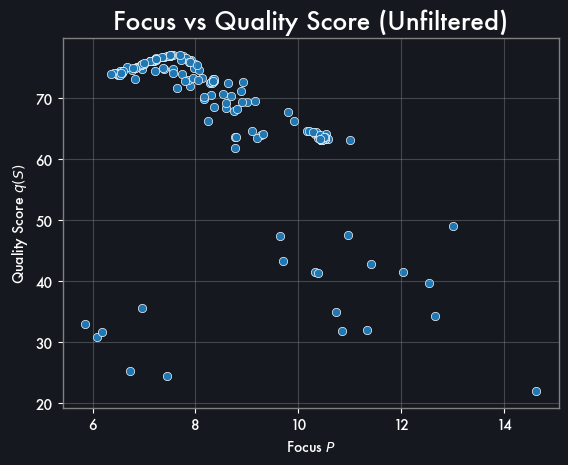

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

#df_q_s_unique.head(3)
sns.scatterplot(data=df_q_s_unique, x=DSN_SMPL_P, y=DSN_SMPL_QUALITY_SCORE)
plt.title("Focus vs Quality Score (Unfiltered)")
plt.xlabel("Focus $P$")
plt.ylabel("Quality Score $q(S)$")
plt.savefig(output_paths[DSN_PLT_PATH_FOCUS_VS_QUALITY_UNFILTERED], dpi=150, bbox_inches='tight')
plt.show()

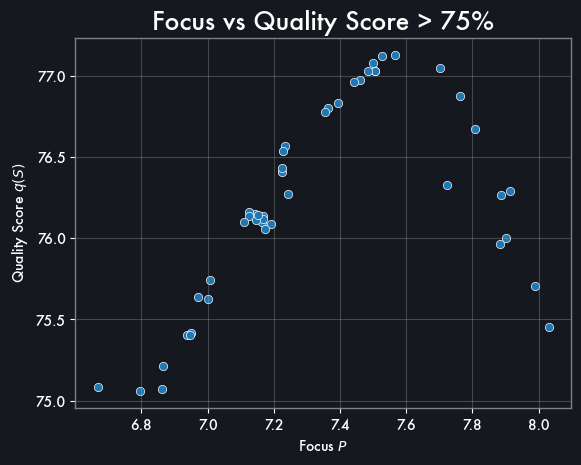

In [8]:
threshold   = 75
df_q_s_unique_filtered = df_q_s_unique[df_q_s_unique[DSN_SMPL_QUALITY_SCORE] > threshold].copy()

sns.scatterplot(data=df_q_s_unique_filtered, 
                x=DSN_SMPL_P, 
                y=DSN_SMPL_QUALITY_SCORE)
plt.title(f"Focus vs Quality Score > {threshold}%")
plt.xlabel("Focus $P$")
plt.ylabel("Quality Score $q(S)$")
plt.savefig(output_paths[DSN_PLT_PATH_FOCUS_VS_QUALITY_THRESHOLD], dpi=150, bbox_inches='tight')
plt.show()

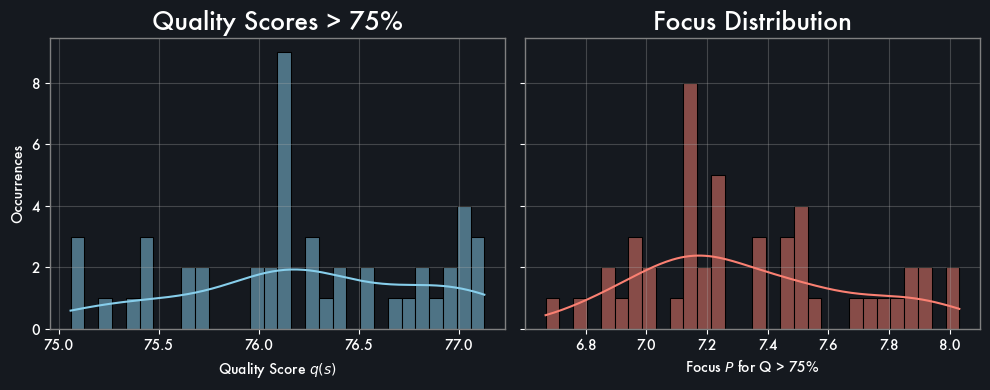

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Quality Score distribution
sns.histplot(df_q_s_unique_filtered[DSN_SMPL_QUALITY_SCORE], bins=30, kde=True, color="skyblue", ax=axs[0])
axs[0].set_title(f"Quality Scores > {threshold}%")
axs[0].set_xlabel("Quality Score $q(s)$")
axs[0].set_ylabel("Occurrences")
axs[0].grid(True)

# x_p distribution
sns.histplot(df_q_s_unique_filtered[DSN_SMPL_P], bins=30, kde=True, color="salmon", ax=axs[1])
axs[1].set_title("Focus Distribution")
axs[1].set_xlabel(f"Focus $P$ for Q > {threshold}%")
axs[1].grid(True)

plt.tight_layout()
plt.savefig(output_paths[DSN_PLT_PATH_FOCUS_QUALITY_DISTRIBUTION], dpi=150, bbox_inches='tight')
plt.show()


# $Y$ with the Best Quality Score

## Selecting 3 Focus Values

In [10]:
df_sorted       = df_q_s_unique_filtered.sort_values(by=DSN_SMPL_P).reset_index(drop=True)
num_y_per_group = 1

# Lowest X_p above threshold
focus_low               = df_sorted.head(num_y_per_group).copy()
focus_low["P_group"]  = 0

# Highest X_p above threshold
focus_high              = df_sorted.tail(num_y_per_group).copy()
focus_high["P_group"] = 2  

# Median X_p
median_index            = len(df_sorted) // 2
focus_mid               = df_sorted.iloc[[median_index]].copy()
focus_mid["P_group"]  = 1

# Combining
df_top_x_p_groups = pd.concat([focus_low, focus_mid, focus_high], ignore_index=True)
df_top_x_p_groups


,seed,P,ae_mean,ae_90,ae_under_15,sw_median,e_std,quality_score,P_group
0,2872344992,6.668426,2.915675,5.294434,1.000000,32.994812,0.113607,75.083400,0
1,3107904129,7.226969,4.721623,8.068839,1.000000,31.923691,0.056689,76.534506,1
2,2898917911,8.031085,7.630256,12.656258,0.987654,30.545502,0.118350,75.450254,2


## Plots of Each Focus Value

### Lowest Focus Value

In [11]:
from usat_designer.processing.plots_usat_designer import *
from universal_transcoder.calculations.pressure_velocity import *

In [12]:
focus_groups = {
    "low":  focus_low,
    "mid":  focus_mid,
    "high": focus_high
}

focus_plot_data = {}

for label, focus_df in focus_groups.items():
    seed = focus_df[DSN_SMPL_SEED].iloc[0]
    row  = df[df[DSN_SMPL_SEED] == seed].iloc[0]

    S      = row[DSN_OUT_SPEAKER_MATRIX]
    cloud  = row[DSN_OUT_CLOUD]
    layout = row[DSN_OUT_OUTPUT_LAYOUT]

    ri = radial_I_calculation(cloud, S, layout)
    ti = transverse_I_calculation(cloud, S, layout)

    focus_plot_data[label] = {
        DSN_PLT_ENERGY_TITLE: energy_calculation(S),
        DSN_PLT_PRESSURE_TITLE: pressure_calculation(S),
        DSN_PLT_RADIAL_I_TITLE: ri,
        DSN_PLT_TRANSVERSE_I_TITLE: ti,
        DSN_PLT_RADIAL_V_TITLE: radial_V_calculation(cloud, S, layout),
        DSN_PLT_TRANSVERSE_V_TITLE: transversal_V_calculation(cloud, S, layout),
        DSN_PLT_ANGULAR_ERROR_TITLE: angular_error(ri, ti),
        DSN_PLT_SOURCE_WIDTH_TITLE: width_angle(ri),
        "cloud": cloud
    }

### Energy Comparison

In [13]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib.image import imread
from io import BytesIO
import base64

def plot_focus_grid(focus_plot_data, metric_settings, colormap=None, dpi=150, save_path=None):
    """
    Display scalar map comparisons across focus groups and metrics using plot_scalar_map().

    Args:
        focus_plot_data (dict): Dict with keys "low", "mid", "high", each containing metric arrays and cloud.
        metric_settings (list): List of dicts with keys:
            - 'key': key in focus_plot_data
            - 'label': label for colorbar
            - 'clim': tuple (min, max)
        colormap (Colormap): Matplotlib colormap to use (LinearSegmentedColormap or str).
        dpi (int): DPI used for plot_scalar_map.
    """

    # Focus labels and metric list
    focus_labels    = list(focus_plot_data.keys())
    num_rows        = len(metric_settings)
    num_cols        = len(focus_labels)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    if num_rows == 1:
        axs = [axs]
    if num_cols == 1:
        axs = [[ax] for ax in axs]

    for row_idx, metric in enumerate(metric_settings):
        metric_key = metric["key"]
        label = metric["label"]
        clim = metric["clim"]

        for col_idx, focus in enumerate(focus_labels):
            data = focus_plot_data[focus]
            cloud = data["cloud"]

            title_text = f"{metric_key.capitalize()} ({focus})"

            img_b64 = plot_scalar_map(
                values=data[metric_key],
                cloud_points=cloud,
                title=title_text,
                colorbar_label=label,
                clim_range=clim,
                cmap=colormap,
                dpi=dpi,
                return_base64=True
            )

            img_bytes = base64.b64decode(img_b64)
            img_array = imread(BytesIO(img_bytes), format='png')

            ax = axs[row_idx][col_idx]
            ax.imshow(img_array)
            ax.axis('off')

            # Add row labels on the left
            if col_idx == 0:
                ax.set_ylabel(label, fontsize=14)

            # Add column titles at the top
            if row_idx == 0:
                ax.set_title(focus.capitalize(), fontsize=14)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

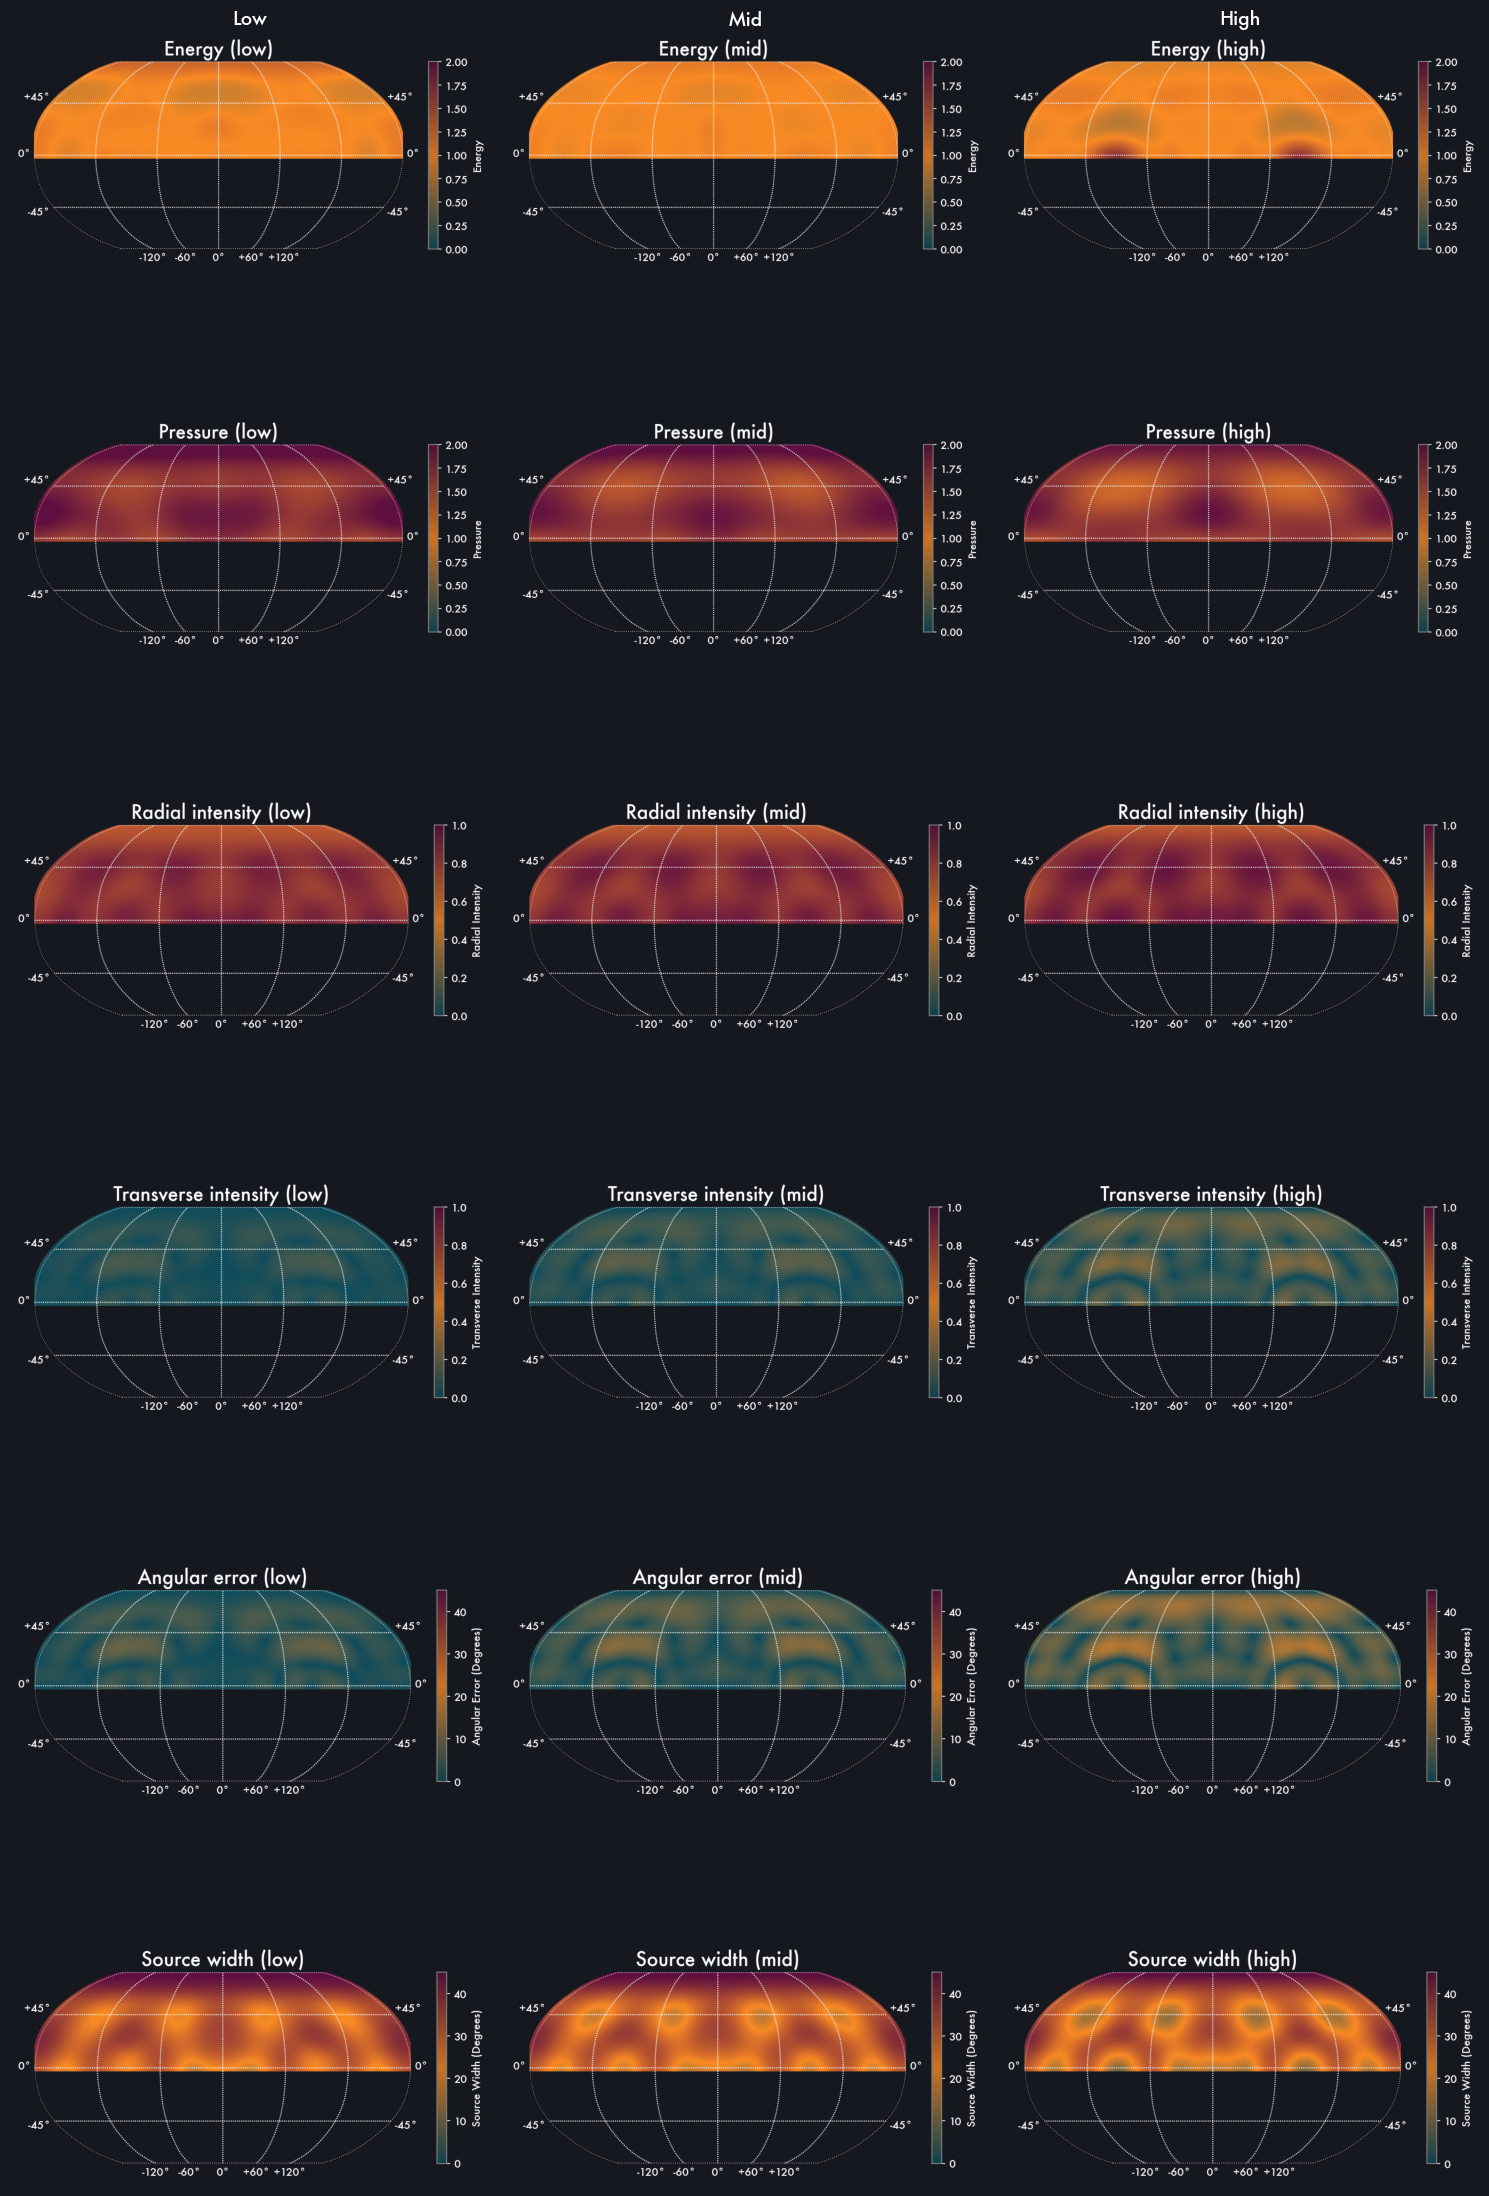

In [14]:
# Custom colormap
colors = [
    DSN_PLT_GRADIENT_COOL,
    DSN_PLT_GRANDIENT_NEUTRAL,
    DSN_PLT_GRADIENT_WARM
]
cmap = LinearSegmentedColormap.from_list("custom_coolwarm", colors)

# Define metrics to display
metric_settings = [
    {"key": DSN_PLT_ENERGY_TITLE,          "label": "Energy",                   "clim": (0, 2)},
    {"key": DSN_PLT_PRESSURE_TITLE,        "label": "Pressure",                 "clim": (0, 2)},
    {"key": DSN_PLT_RADIAL_I_TITLE,        "label": "Radial Intensity",         "clim": (0, 1)},
    {"key": DSN_PLT_TRANSVERSE_I_TITLE,    "label": "Transverse Intensity",     "clim": (0, 1)},
    {"key": DSN_PLT_ANGULAR_ERROR_TITLE,   "label": "Angular Error (Degrees)",  "clim": (0, 45)},
    {"key": DSN_PLT_SOURCE_WIDTH_TITLE,    "label": "Source Width (Degrees)",   "clim": (0, 45)},
]

plot_focus_grid(focus_plot_data, 
                metric_settings, 
                colormap=cmap, 
                dpi=150, 
                save_path=output_paths[DSN_PLT_PATH_FOCUS_GRID])


# Extract XML File

In [15]:
import shutil
import xml.etree.ElementTree as ET
import os

def wrap_xml_with_usat_designer(input_path, output_path):
    tree = ET.parse(input_path)
    root = tree.getroot()

    new_root = ET.Element("USAT_Designer")
    new_root.append(root)

    new_tree = ET.ElementTree(new_root)
    new_tree.write(output_path, encoding="utf-8", xml_declaration=True)

seed_low  = focus_low.seed.iloc[0]
seed_mid  = focus_mid.seed.iloc[0]
seed_high = focus_high.seed.iloc[0]

folder_low  = df.loc[df['seed'] == seed_low, 'folder'].values[0]
folder_mid  = df.loc[df['seed'] == seed_mid, 'folder'].values[0]
folder_high = df.loc[df['seed'] == seed_high, 'folder'].values[0]

xml_low  = os.path.join(folder_low,  f"y_parameters_{seed_low}.xml")
xml_mid  = os.path.join(folder_mid,  f"y_parameters_{seed_mid}.xml")
xml_high = os.path.join(folder_high, f"y_parameters_{seed_high}.xml")

dest_low  = output_paths[DSN_PARAMS_PATH_LOW]
dest_mid  = output_paths[DSN_PARAMS_PATH_MID]
dest_high = output_paths[DSN_PARAMS_PATH_HIGH]

# Wrap and save the XMLs directly to destination folders
wrap_xml_with_usat_designer(xml_low,  os.path.join(dest_low,  dest_low))
wrap_xml_with_usat_designer(xml_mid,  os.path.join(dest_mid,  dest_mid))
wrap_xml_with_usat_designer(xml_high, os.path.join(dest_high, dest_high))